In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# 1. Загрузка данных
df = pd.read_csv('./content/cybersequrity.csv')

# Просмотр первых 5 строк
print(df.head())

   svcscan.fs_drivers  callbacks.ngeneric  \
0                  26                   8   
1                  26                   8   
2                  26                   8   
3                  26                   8   
4                  26                   8   

   psxview.not_in_eprocess_pool_false_avg  psxview.not_in_eprocess_pool  \
0                                     0.0                             0   
1                                     0.0                             0   
2                                     0.0                             0   
3                                     0.0                             0   
4                                     0.0                             0   

   callbacks.nanonymous  psxview.not_in_session  psxview.not_in_pslist  \
0                     0                       2                      0   
1                     0                       5                      3   
2                     0                       9         

In [3]:
# 2. Определение признаков и целевой переменной
X = df.drop(columns='Class').values  # Все столбцы, кроме 'Class'
y = df['Class'].values  # Целевая переменная

# Разделение на обучающую, валидационную и тестовую выборки (60/20/20) со стратификацией
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [4]:
# 3. Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
# 4. Преобразование данных в тензоры
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)

In [6]:
# 5. Создание класса Dataset
class CybersecurityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [7]:
# 6. Выбор batch_size
batch_size = 32

In [8]:
# 7. Создание DataLoader
train_dataset = CybersecurityDataset(X_train_tensor, y_train_tensor)
val_dataset = CybersecurityDataset(X_val_tensor, y_val_tensor)
test_dataset = CybersecurityDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# 8. Проверка размерностей выборок
print(f'Train size: {len(train_loader)}, Validation size: {len(val_loader)}, Test size: {len(test_loader)}')

Train size: 188, Validation size: 63, Test size: 63


### Реализация класса MLP

1. Структура модели: Мы используем несколько линейных слоев для обработки данных.
2. Функции активации: Часто используемыми функциями активации в скрытых слоях являются ReLU и LeakyReLU.
3. Метод forward: Реализуем логику прохождения данных через сеть.

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        
        # Определяем слои
        layers = []
        in_dim = input_dim
        
        # Создаем скрытые слои
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())  # Используем активацию ReLU
            in_dim = hidden_dim
        
        # Выходной слой
        layers.append(nn.Linear(in_dim, output_dim))
        layers.append(nn.Sigmoid())  # Используем сигмоид для бинарной классификации
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Параметры модели
input_dim = X_train.shape[1]  # Количество входных признаков
hidden_dims = [64, 32]  # Размерности скрытых слоев
output_dim = 1  # Для бинарной классификации

# Создание объекта модели
model = MLP(input_dim, hidden_dims, output_dim)

# Проверка наличия GPU и перевод модели на GPU, если доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### Обучение и валидации модели

Epoch [1/50], Train Loss: 0.6675, Val Loss: 0.6451
Epoch [2/50], Train Loss: 0.6374, Val Loss: 0.6239
Epoch [3/50], Train Loss: 0.6105, Val Loss: 0.5936
Epoch [4/50], Train Loss: 0.5774, Val Loss: 0.5580
Epoch [5/50], Train Loss: 0.5474, Val Loss: 0.5340
Epoch [6/50], Train Loss: 0.5296, Val Loss: 0.5176
Epoch [7/50], Train Loss: 0.5082, Val Loss: 0.4995
Epoch [8/50], Train Loss: 0.5024, Val Loss: 0.5011
Epoch [9/50], Train Loss: 0.4910, Val Loss: 0.4854
Epoch [10/50], Train Loss: 0.4819, Val Loss: 0.4755
Epoch [11/50], Train Loss: 0.4846, Val Loss: 0.4806
Epoch [12/50], Train Loss: 0.4793, Val Loss: 0.4738
Epoch [13/50], Train Loss: 0.4735, Val Loss: 0.4674
Epoch [14/50], Train Loss: 0.4716, Val Loss: 0.4683
Epoch [15/50], Train Loss: 0.4674, Val Loss: 0.4646
Epoch [16/50], Train Loss: 0.4629, Val Loss: 0.4626
Epoch [17/50], Train Loss: 0.4635, Val Loss: 0.4890
Epoch [18/50], Train Loss: 0.4595, Val Loss: 0.4759
Epoch [19/50], Train Loss: 0.4630, Val Loss: 0.4580
Epoch [20/50], Train 

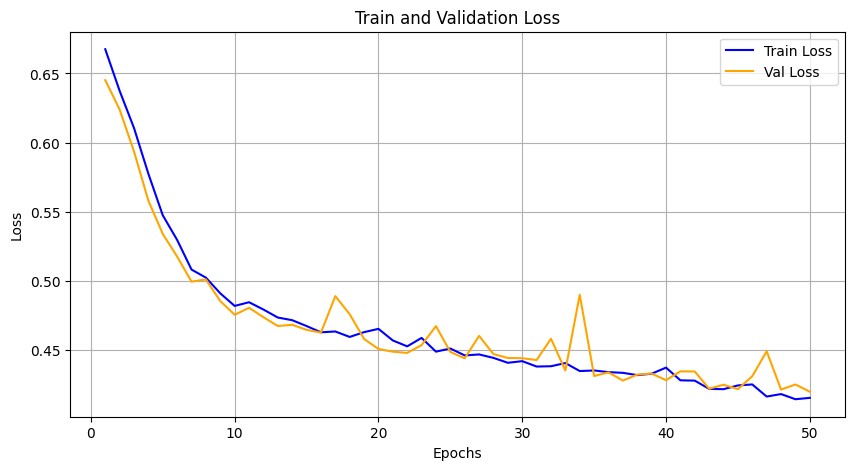

In [11]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()  # Функция потерь для бинарной классификации
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam

# Параметры обучения
num_epochs = 50

train_losses = []
val_losses = []

def train(model, train_loader, criterion, optimizer):
    model.train()  # Устанавливаем режим обучения
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)  # Перенос данных на устройство
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(features).squeeze()  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисляем функцию потерь
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем параметры
        running_loss += loss.item()  # Сохраняем потери

    return running_loss / len(train_loader)  # Возвращаем среднюю потерю

def evaluate(model, val_loader, criterion):
    model.eval()  # Устанавливаем режим валидации
    running_loss = 0.0
    with torch.no_grad():  # Выключаем градиенты
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(val_loader)  # Возвращаем среднюю потерю

# Цикл обучения и валидации
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Тестирование модели
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features).squeeze()
        predicted = (outputs > 0.5).float()  # Преобразуем вероятности в класс
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.numpy())

In [13]:
# Отчет о классификации

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       981
         1.0       0.78      0.82      0.80      1019

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [14]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(ImprovedMLP, self).__init__()
        layers = []
        in_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))  # Слой нормализации
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # Dropout
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, output_dim))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Определение гиперпараметров
dropout_rate = 0.3  
# - **Оптимальное значение p**: Значение p (доля отключаемых нейронов) обычно выбирается между 0.2 и 0.5
# Значение 0.3 является хорошим гибридом, поскольку оно обычно демонстрирует хорошую производительность в различных задачах.

hidden_dims = [64, 32]  # Размерности скрытых слоев

# Создание и перенос улучшенной модели на устройство
improved_model = ImprovedMLP(input_dim, hidden_dims, output_dim, dropout_rate)
improved_model.to(device)

ImprovedMLP(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [15]:
# Тестирование улучшенной модели
improved_model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = improved_model(features).squeeze()
        predicted = (outputs > 0.5).float()  # Преобразуем вероятности в класс
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.numpy())

In [ ]:
# Отчет о классификации
print("Classification Report for Improved Model:")
print(classification_report(y_true_list, y_pred_list)) 

Classification Report for Improved Model:
              precision    recall  f1-score   support

         0.0       0.40      0.10      0.16       981
         1.0       0.50      0.85      0.63      1019

    accuracy                           0.49      2000
   macro avg       0.45      0.48      0.40      2000
weighted avg       0.45      0.49      0.40      2000



### Обоснование архитектуры и гиперпараметров

Мы начинаем с простой многослойной MLP модели, потому что она подходит для задач бинарной классификации. Модель состоит из нескольких линейных слоев с функцией активации ReLU, которая хороша для устранения проблемы затухающего градиента и даёт хорошие результаты в большинстве задач глубокого обучения

- **Скрытые слои**: Мы выбрали два скрытых слоя с размерностями 64 и 32, что дает модели возможность обучаться сложным представлениям данных, прежде чем переходить к выходному слою. Более глубокие сети могут улучшить качество, но могут вести к переобучению
- **Функция активации**: Для внутренних слоев использована функция активации ReLU, так как она обычно показывает хорошие результаты и обеспечивается быстрыми вычислениями. Выходной слой использует Sigmoid, так как мы решаем задачу бинарной классификации
